## Rouwenhorst Method
Discretizing an AR(1) process 

#### Preliminaries

In [1]:
# load some packages
import matplotlib.pyplot as plt
import numpy as np

# config
RHO = 0.5  # convergence to mean
SIGMA = 0.01  # standard deviation
N = 51  # number of gridpoints

#### Method
The Rouwenhorst Method lets us discretize an AR(1) random process to $N$ evenly spaced gridpoints between $-\psi$ and $\psi$ mapped to by a Markov Matrix.

The method starts with two parameters $p, q \in (0, 1)$. Then, when $N=2$, we have
$$
    \mathbf{\Pi}_2 = \begin{pmatrix}
        p & 1-q \\
        1-p & q
    \end{pmatrix}
$$
and for $N > 2$ we define it recursively using
$$
    p \begin{pmatrix}
        \mathbf{\Pi}_{N-1} & 0 \\
        0 & 0
    \end{pmatrix} + (1-p) \begin{pmatrix}
        0 & 0 \\
        \mathbf{\Pi}_{N-1} & 0
    \end{pmatrix} + (1-q) \begin{pmatrix}
        0 & \mathbf{\Pi}_{N-1} \\
        0 & 0
    \end{pmatrix} + q \begin{pmatrix}
        0 & 0 \\
        0 & \mathbf{\Pi}_{N-1}
    \end{pmatrix}
$$
where to get $\mathbf{\Pi}_N$ we divide all columns except the first and last by 2 so they sum to 1.

As a note, this is technically not the Rouwenhorst matrix, and is instead it's transpose. I like this more so we can use eigenvectors to get stable distributions, but to get expectations you'll need to either multiply with this matrix on the right (not left like normal) or use the transpose.

#### Implementation

In [2]:
def rouwenhorst_tran_mat(p, q, N):
    # N < 2 is invalid
    if N < 2:
        raise ValueError('N should be >= 2')

    # exit condition, N=2
    if N == 2:
        return np.array([
                [p, 1-q],
                [1-p, q],
            ])
    
    # create transition matrix
    mat_N_l = rouwenhorst_tran_mat(p, q, N-1)  # recurisve def
    mat = np.zeros((N, N))  # starting point
    mat[:-1, :-1] += p * mat_N_l  # top left
    mat[1:, :-1] += (1-p) * mat_N_l  # bottom left
    mat[:-1, 1:] += (1-q) * mat_N_l  # top right
    mat[1:, 1:] += q * mat_N_l  # bottom right
    mat[:, 1:-1] /= 2  # sum to 1

    return mat

#### AR(1) Process
We'll model the transitions of the AR(1) process
$$
    y_t = \rho y_{t-1} + \varepsilon_t
$$
where $\varepsilon_t \sim \mathcal{N}(0, \sigma)$. This process follows a normal distribution $y_t \sim \mathcal{N} (0, \sigma_y)$ where
$$
    \sigma_y^2 = \frac{\sigma^2}{1-\rho^2}.
$$

Using Rouwenhorst Method, this can be modeled using
$$
    p = q = \frac{1 + \rho}{2}
$$
and
$$
    \psi = \sigma_y \sqrt{N - 1}.
$$

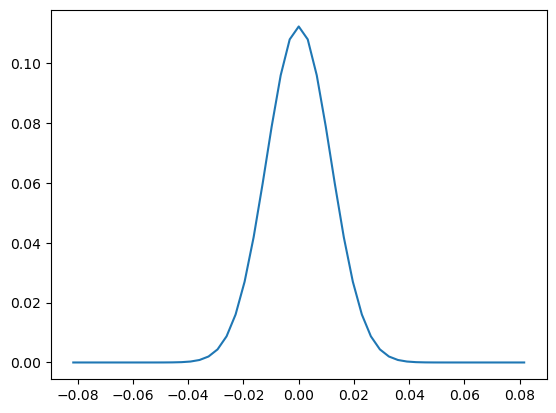

In [3]:
# simulation params
sigma_y = np.sqrt(SIGMA**2 / (1 - RHO**2))  # standard deviation in ar1 process
pq = (1 + RHO) / 2  # p = q
psi = sigma_y * np.sqrt(N - 1)  # max/min gridpoint, finer grid that spreads out more as N increases
grid = np.linspace(-psi, psi, N)  # to map to logs, the grid becomes exp(grid)

# transition probabilities
tran_mat = rouwenhorst_tran_mat(pq, pq, N)

# get stationary distribution
vals, vecs = np.linalg.eig(tran_mat)
i = np.abs(vals).argmax()  # markox matrix -> this is 1
dist = vecs[:, i].real  # imaginary opart is always 0
dist /= dist.sum()  # normalize

# plot
plt.plot(grid, dist)

#### Function
We know a normal distribution can be calculated as
$$
    \frac{1}{\sigma_y \sqrt{2\\pi}} e^{\frac{x^2}{2 \sigma_y^2}}.
$$

We'll calculate this function, adjust it to our grid size, and compare it to our Rouwenhorst method distribution.

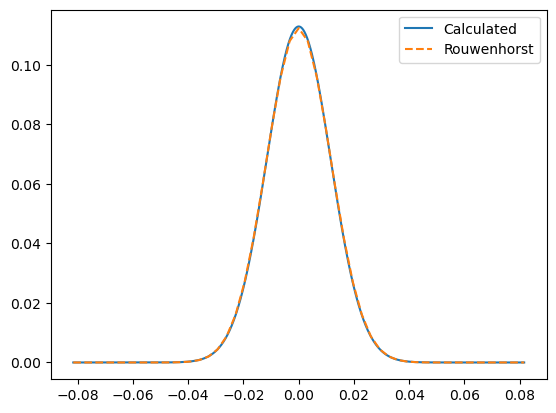

In [4]:
dy = grid[1] - grid[0]

## use gaussian function
fine_grid = np.linspace(-psi, psi, 10001)
calc_dist = 1 / (sigma_y * np.sqrt(2*np.pi)) * np.exp(-0.5 * fine_grid**2 / sigma_y**2) * dy # normal pdf adjusted to match gridpoint size 

# plot it
plt.plot(fine_grid, calc_dist, label='Calculated')
plt.plot(grid, dist, '--', label='Rouwenhorst')
plt.legend()

#### Simulation
We can also simulate the AR(1) process to see how the calculated distribution compares.

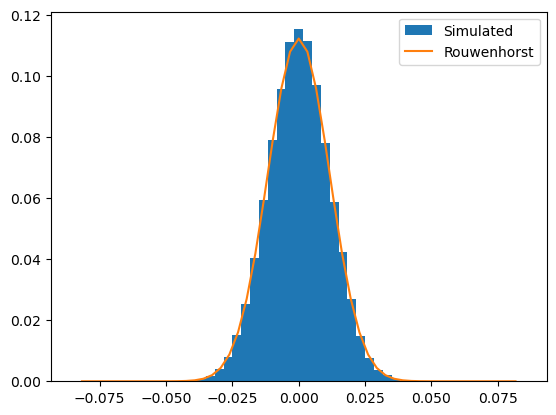

In [5]:
# params
sim_n = 100000
sim_iter = 1000
np.random.seed(10)

# sim
vals = np.random.normal(0, SIGMA, sim_n)  # start with error
for _ in range(sim_iter):
    vals = RHO * vals + np.random.normal(0, SIGMA, sim_n)  # ar1 equation

# plot it
plt.hist(vals, weights=np.full(sim_n, 1/sim_n), bins=np.linspace(-psi-dy, psi+dy, N+1), label='Simulated')
plt.plot(grid, dist, label='Rouwenhorst')
plt.legend()